In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

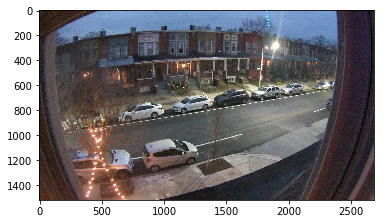

In [35]:
cal_path = "mounted-cars/calibration.jpg"
cal_color = cv2.flip(cv2.imread(cal_path), -1 ) #read & flip
plt.imshow(cv2.cvtColor(cal_color, cv2.COLOR_BGR2RGB))

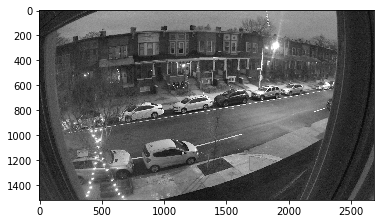

In [36]:
cal_path = "mounted-cars/calibration.jpg"
cal = cv2.flip(cv2.imread(cal_path, cv2.IMREAD_GRAYSCALE), -1 ) #read & flip
plt.imshow(cal, cmap='gray')

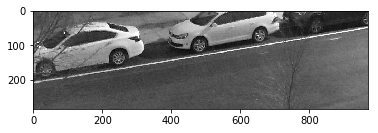

In [40]:
get_roi= lambda im: im[706:990, 680:1650]
plt.imshow(get_roi(cal), cmap='gray')

In [79]:
import numpy as np
car_p1 = np.array([745, 881])
car_p2 = np.array([900, 856])
car_length_px = np.linalg.norm(car_p2 - car_p1)
px_2_m = lambda px: 1.93 * (px / car_length_px)
m_2_px = lambda m: (m / 1.93) * car_length_px
print("pixels per meter= {}".format(m_2_px(1)))
mps_2_mph = lambda mps: mps * 2.23694

pixels per meter= 81.34880035288904


In [45]:
# for two frames
paths=[
    'mounted-cars/2018-12-27T17/07/10.167307.jpg',
    'mounted-cars/2018-12-27T17/07/10.792036.jpg',
]
# compare the time
# crop to ROI
# find the max value (maybe headlight?)
# compute the distance

In [83]:
import dateutil.parser
def parse_time(path):
    time_s = path.split("mounted-cars/")[1][:-4].replace('/', ':')
    return dateutil.parser.parse(time_s)
t0 = parse_time(paths[0])
t1 = parse_time(paths[1])

def get_max_in_roi(path):
    im = cv2.flip(cv2.imread(path, cv2.IMREAD_GRAYSCALE), -1 ) # read & flip
    roi = get_roi(cal)
    
    x, y = np.unravel_index(roi.argmax(), roi.shape)
    return [x, y]

delta_t = t1 - t0

p0 = get_max_in_roi(paths[0])
p1 = get_max_in_roi(paths[1])

print(p0)
print(p1)

delta_p_m = 26.0
speed_m = delta_p_m / delta_t.total_seconds()
mps_2_mph(speed_m)

[0, 568]
[0, 568]


93.0970708899379